In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

print("[INFO] Loading MNIST dataset...")
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)
print("[INFO] Dataset loaded...")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15,
                                                    random_state=42)


[INFO] Loading MNIST dataset...
[INFO] Dataset loaded...


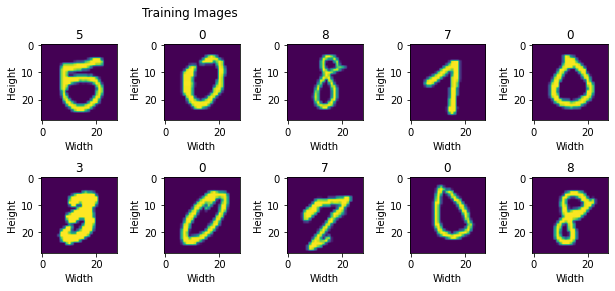

In [2]:
# Display the first 10 images in the training set and their associated labels
plt.figure()

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_train[i].reshape(28,28))
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title(np.argmax(y_train[i]))

plt.subplots_adjust(right=1.5, top=0.85, hspace=0.75)
plt.suptitle("Training Images")
plt.show()

In [3]:
class NeuralNet():
    def __init__(self, epochs=10, l_rate=0.001):
        self.sizes = []
        self.epochs = epochs
        self.LR = l_rate
        self.layers = 0

        # we save all parameters in the neural network in these dictionary
        self.params = {}
        self.weights = {}
        self.activations = {}

    '''
    Activation functions to be used in the network
    '''
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def relu(self, x):
      if x < 0:
        return 0
      return x

    '''
    Implementation of the neural  network
    '''
    def initialization(self):
        
        # Set number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        #Create the data structures that will be used to store the weights and activations
        #of the network
        params = {
            0 : np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            1 : np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            2 : np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        activations = {}
        for i in range(self.layers):
          activations[i] = 0

        weights = {}
        for i in range(self.layers-1):
          weights[i] = 0

        return params, activations, weights

    def add_layer(self, num_params):
      self.layers += 1
      self.sizes.append(num_params)

    def num_layers(self):
      return self.layers

    def forward(self, x_train):
        params = self.params
        weights = self.weights
        activations = self.activations

        # input layer activations becomes sample
        activations[0] = x_train
        
        for i in range(self.layers-1):
          weights[i] = np.dot(params[i], activations[i])
          if i < 2:
            activations[i+1] = self.sigmoid(weights[i])
          else:
            activations[i+1] = self.softmax(weights[i])

        return activations[3]

    def backprop(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.
        '''
        params = self.params
        weights = self.weights
        activations = self.activations
        change_w = {}

        #Calculate the update to the weights of each layer
        for i in range(self.layers-1):
          if i == 0:
            error = 2 * (output - y_train) / output.shape[0] * self.softmax(weights[3-(i+1)], derivative=True)
          else:
            error = np.dot(params[3-i].T, error) * self.sigmoid(weights[3-(i+1)], derivative=True)
          
          change_w[3-(i+1)] = np.outer(error, activations[3-(i+1)])

        return change_w

    def update_network_parameters(self, changes_to_w):
        
        '''
            This function updates the network parameters based on the SGD 
            update rule
        '''       
        for key, value in changes_to_w.items():
            self.params[key] -= self.LR * value

    def compute_accuracy(self, x_test, y_test):

        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_test, y_test):
            output = self.forward(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_test, y_test):
        # Initialize the dictionaries with network parameters, weights
        # and activation functions
        self.params, self.activations, self.weights = self.initialization()

        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward(x)
                changes_to_w = self.backprop(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_test, y_test)

            #Output to show the progress of the training
            print(f'Epoch: {iteration+1}: Time Spent: {time.time() - start_time}s, Accuracy: {accuracy * 100}%')
      
    def predict(self, x_test):     
      return self.forward(x_test)


In [4]:
# Create neural network object and train the network
model = NeuralNet(epochs=10)
model.add_layer(784)
model.add_layer(128)
model.add_layer(64)
model.add_layer(10)
model.train(x_train, y_train, x_test, y_test)

Epoch: 1: Time Spent: 53.97194051742554s, Accuracy: 18.495238095238093%
Epoch: 2: Time Spent: 107.92636752128601s, Accuracy: 26.676190476190477%
Epoch: 3: Time Spent: 161.93071866035461s, Accuracy: 32.971428571428575%
Epoch: 4: Time Spent: 216.50318813323975s, Accuracy: 36.266666666666666%
Epoch: 5: Time Spent: 270.66773080825806s, Accuracy: 39.14285714285714%
Epoch: 6: Time Spent: 324.5791778564453s, Accuracy: 42.076190476190476%
Epoch: 7: Time Spent: 379.1480641365051s, Accuracy: 44.84761904761905%
Epoch: 8: Time Spent: 433.21108770370483s, Accuracy: 47.65714285714286%
Epoch: 9: Time Spent: 487.14169120788574s, Accuracy: 50.02857142857143%
Epoch: 10: Time Spent: 541.8052144050598s, Accuracy: 51.97142857142857%


In [11]:
# Make a prediction using the model
output = model.predict(x_test[3])

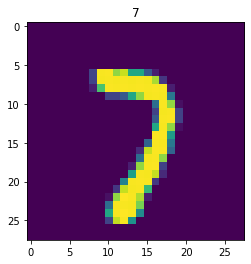


Number: 7
Prediction: 7


In [13]:
# Visualize the output of the model
plt.figure()
plt.imshow(x_test[3].reshape(28,28))
plt.title(np.argmax(output))
plt.show()

print(f"\nNumber: {np.argmax(y_test[3])}\nPrediction: {np.argmax(output)}")